In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor  #used to predict continuous target variables
from sklearn.ensemble import RandomForestRegressor  #A machine learning algorithm that fits multiple decision trees on various sub-samples of the dataset and averages their predictions to improve accuracy and control over-fitting
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler  # A preprocessing techniques that scale a feature to a fixed range, typically between -1 and 1.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM  #LSTM is well suited for time-series prediction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  #save the model after every epoch and also used for the model optimization

In [26]:
store_sales = pd.read_csv('sales_data.csv')
store_sales.head(7)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10


Check for NULL values in the dataset

In [27]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping "store" and "item" columns

In [28]:
store_sales=store_sales.drop(['store','item'],axis=1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Converting date from object datatype to datetime datatype

In [29]:
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Converting date to a month period, and then adding the number of items in each month

In [30]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

Converting the resulting "date" column to timestamp datatype

In [31]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(7)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922


Monthly Sales Visualization

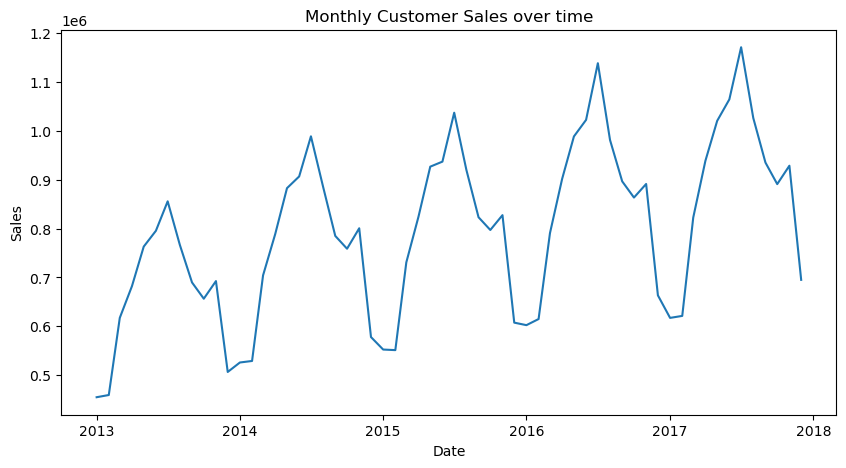

In [35]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales over time')
plt.show()

Call the difference on the "sales" column to make the sales data stationary

In [37]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(7)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0


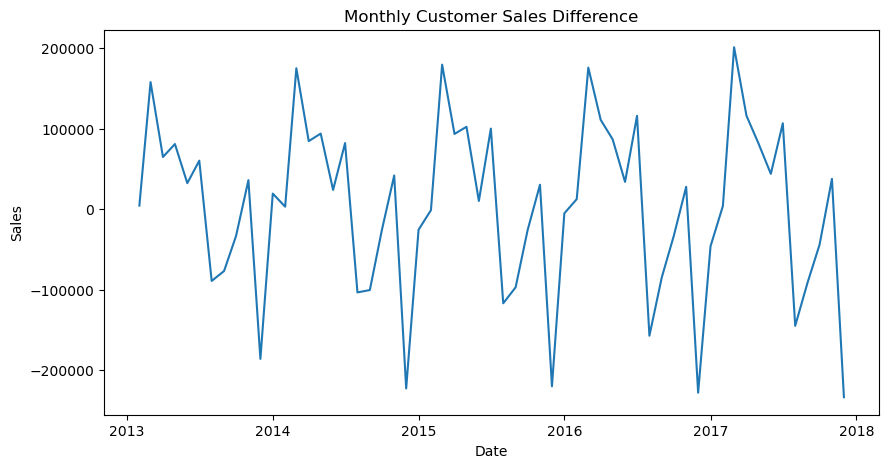

In [40]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Difference')
plt.show()

Dropping off "sales" and "date" column

In [45]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

Preparing Supervised Data

In [47]:
for i in range(1,13):
    col_name = 'month_'+str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(7)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0


Splitting the data into Train data and Test data

In [49]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [56]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [63]:
X_train, y_train = train_data[:, 1:], train_data[:, 0:1]
X_test, y_test = test_data[:, 1:], test_data[:, 0:1]

y_train = y_train.ravel() #ravel() is used to reshape numpy array into 1D array
y_test = y_test.ravel()

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (35, 12)
y_train shape:  (35,)
X_test shape:  (12, 12)
y_test shape:  (12,)


Creating Prediction DataFrame to merge the predicted sales prices of all trained algorithms

In [64]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
print(sales_dates)

0    2017-01-01
1    2017-02-01
2    2017-03-01
3    2017-04-01
4    2017-05-01
5    2017-06-01
6    2017-07-01
7    2017-08-01
8    2017-09-01
9    2017-10-01
10   2017-11-01
11   2017-12-01
Name: date, dtype: datetime64[ns]


In [65]:
actual_sales = monthly_sales['sales'][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Creating the Linear Regression Model and Predict the output

In [67]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [70]:
pred = pred.reshape(-1,1)
# This is a set matrix that contains the input features of test data, and also the predicted output
pred_test_set = np.concatenate([pred, X_test], axis=1)
pred_test_set = scaler.inverse_transform(pred_test_set) #inverse_transform is method of minmaxscaler is used to normalise the data
#pred_test_set now contains the predicted sales differences along with the test features, all in their original scale.

In [88]:
result_list = []
# Generating the predicted sales values by adjusting the actual sales from the previous month by the predicted difference (used to compute the final predicted sales for each month).
for index in range(0, len(pred_test_set)):
    result_list.append(pred_test_set[index][0] + actual_sales[index])

pred_series = pd.Series(result_list, name='Prediction') #This converts result_list into a pandas Series, which is a one-dimensional array with an associated index.
predict_df = predict_df.merge(pred_series, left_index=True, right_index=True)
#The result is that predict_df will now have two columns: the date column and the Linear Prediction column containing the predicted sales values.

In [89]:
print(predict_df)

         date    Prediction
0  2017-01-01  6.403448e+05
1  2017-02-01  6.204223e+05
2  2017-03-01  8.091704e+05
3  2017-04-01  9.342942e+05
4  2017-05-01  1.024649e+06
5  2017-06-01  1.056935e+06
6  2017-07-01  1.192009e+06
7  2017-08-01  9.965534e+05
8  2017-09-01  9.348467e+05
9  2017-10-01  9.006468e+05
10 2017-11-01  9.086417e+05
11 2017-12-01  6.900701e+05


In [90]:
pred_mse = np.sqrt(mean_squared_error(predict_df['Prediction'], monthly_sales['sales'][-12:]))
print("MSE of Model: ", pred_mse)

pred_mae = mean_absolute_error(predict_df['Prediction'], monthly_sales['sales'][-12:])
print("MAE of Model: ", pred_mae)

# The R-squared score (R²) measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
pred_r2 = r2_score(predict_df['Prediction'], monthly_sales['sales'][-12:])
print("R2 Score of Model: ", pred_r2)

MSE of Model:  14859.255189384718
MAE of Model:  11613.78103322819
R2 Score of Model:  0.9920773932028224


Vizualisation of the Predicted sales against the Actual sales

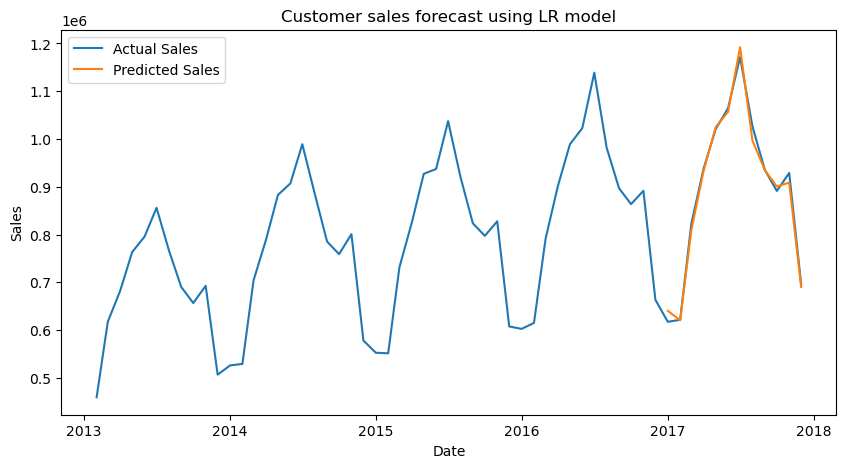

In [92]:
plt.figure(figsize=(10,5))
#Actual Sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#Predicted Sales
plt.plot(predict_df['date'],predict_df['Prediction'])
plt.title("Customer sales forecast using LR model")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()